In [2]:
import numpy as np
import xarray as xr
import pandas as pd

from tqdm import tqdm

from sklearn import preprocessing, model_selection, ensemble, svm, metrics, feature_selection
from sklearn import dummy, model_selection, decomposition, cross_decomposition
from sklearn import multioutput

import matplotlib.pyplot as plt

In [3]:
connectivity_kinds = [
    # 'covariance',
    'correlation',
    'partial_correlation',
    'tangent',
    # 'precision'
]

In [4]:
ATLASES = [
  'dosenbach2007',
  'difumo_64_2',
  # 'difumo_128_2',
  # 'difumo_1024_2'
]

# load the datasets
DATASETS = {
  atlas: xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')
  for atlas in ATLASES}

In [15]:
model = ensemble.GradientBoostingClassifier()

chance_model = dummy.DummyClassifier(strategy='uniform')


# transformer = decomposition.PCA(n_components=5)
# transformer = UMAP(n_components=5)
transformer = cross_decomposition.PLSRegression(n_components=5)

cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=.3)
# cv = model_selection.LeaveOneOut()

scores = []
for atlas, dataset in DATASETS.items():

    valid_beh_subjects_mask = ~np.isnan(dataset['inverse_efficiency_score_ms'].values)
    
    for kind in connectivity_kinds:
        
        # vectorized connectivity matrix (only upper triangle)
        X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=1)] 
                      for subj_conn in dataset[f'{kind}_connectivity'].values])
        X = X[valid_beh_subjects_mask]
        
        X_pivoted = pd.DataFrame(X)
        
        print(X_pivoted.melt(id_vars=['index']))
        
        break
        
        y = preprocessing.LabelEncoder().fit_transform(dataset['group'])
        y = y[valid_beh_subjects_mask]

        y_beh = dataset['inverse_efficiency_score_ms'].values
        y_beh = y_beh[valid_beh_subjects_mask]

        for train, test in tqdm(cv.split(X, y),
                                desc=f'{atlas} ({kind})',
                                total=cv.get_n_splits(X)):

            # feature importance
            # X_train = selector.fit_transform(X[train], y[train])
            # X_test = selector.transform(X[test])

            # dimensionality reduction
            # X_train = reducer.fit_transform(X[train], y[train])
            # X_test = reducer.transform(X[test])
            # X_train, y_train = transformer.fit_transform(X_train, y[train])
            # X_test, y_test = transformer.transform(X_test, y[test])

            # classification
            model.fit(X[train], y[train])
            chance_model.fit(X[train], y[train])

            # prediction
            y_pred = model.predict(X[test])
            y_chance = chance_model.predict(X[test])

            # evaluate
            # score = metrics.roc_auc_score(y[test], y_pred)
            score = metrics.accuracy_score(y[test], y_pred)
            # score = metrics.mean_squared_error(y_test, y_pred)
            scores.append((atlas, kind, score))

            # DEBUG chance level
            # chance_score = metrics.roc_auc_score(y[test], y_chance)
            chance_score = metrics.accuracy_score(y[test], y_chance)      
            # chance_score = metrics.mean_squared_error(y_test, y_chance)
            scores.append((atlas + '_chance', kind, chance_score))

scores = pd.DataFrame(scores, columns=['atlas', 'kind', 'score'])

KeyError: "The following 'id_vars' are not present in the DataFrame: ['index']"

In [88]:
scores.groupby(['atlas','kind']).mean()

score
atlas                kind                      
difumo_64_2          correlation           0.46
                     partial_correlation   0.70
                     tangent               0.55
difumo_64_2_chance   correlation           0.51
                     partial_correlation   0.48
                     tangent               0.62
dosenbach2007        correlation           0.53
                     partial_correlation   0.39
                     tangent               0.48
dosenbach2007_chance correlation           0.45
                     partial_correlation   0.49
                     tangent               0.47

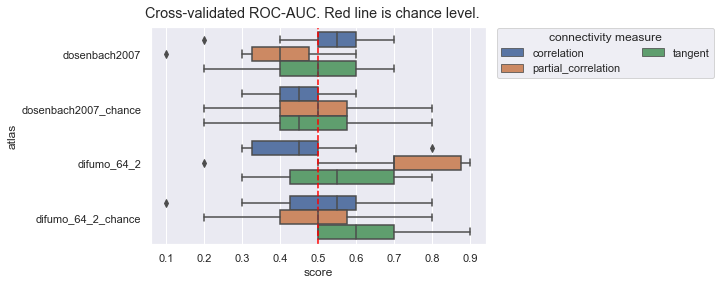

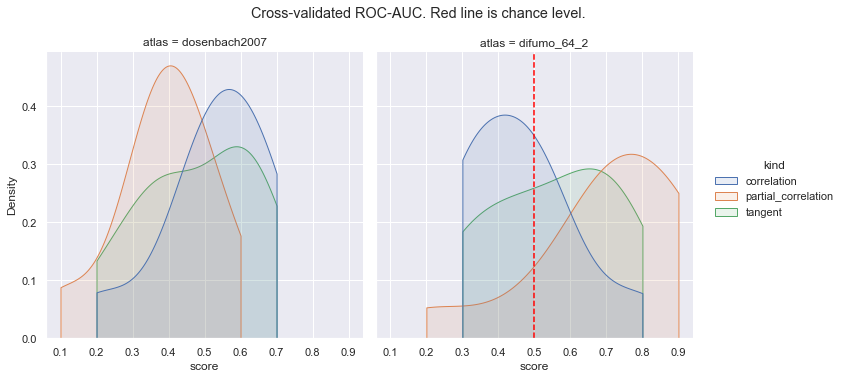

In [89]:
import pandas as pd
import seaborn as sns; sns.set()

# box/violin plot
g = sns.boxplot(data=scores,
            y='atlas',
            x='score',
            hue='kind',
            dodge=True,
            orient='horizontal')

g.legend(loc='upper right', ncol=2, bbox_to_anchor=(1.7, 1.02), title='connectivity measure')

plt.axvline(.5, color='red', linestyle='--')

plt.suptitle('Cross-validated ROC-AUC. Red line is chance level.', y=.95)
plt.show()

# dist plot
sns.displot(
  data=scores.query('not atlas.str.contains("chance")'),
  x='score', hue='kind',
  kind='kde', col='atlas', col_wrap=2,
  clip=(0,1), cut=0,
  fill=True,  alpha=.12)

g.set(ylabel='density')

plt.suptitle('Cross-validated ROC-AUC. Red line is chance level.', y=1.05)

# # plot chance line
plt.axvline(.5, color='red', linestyle='--')

plt.show()